In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from statsmodels.tools.eval_measures import mse, rmse
from wordcloud import WordCloud
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn import tree
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn import neighbors
from IPython.display import Image
from sklearn import metrics
from sklearn.metrics import pairwise_distances



import pydotplus
from sklearn import ensemble

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')
import time

In [30]:
trains_df = (pd.read_csv('Data/AmtrakNJ/2018_04.csv'))
df_trains = trains_df

In [31]:
#examine the data frame

print(
    df_trains.head(),
    df_trains.info(),
    df_trains.describe()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256267 entries, 0 to 256266
Data columns (total 13 columns):
date              256267 non-null object
train_id          256267 non-null object
stop_sequence     242793 non-null float64
from              256267 non-null object
from_id           256267 non-null int64
to                256267 non-null object
to_id             256267 non-null int64
scheduled_time    242793 non-null object
actual_time       256267 non-null object
delay_minutes     242793 non-null float64
status            256267 non-null object
line              256267 non-null object
type              256267 non-null object
dtypes: float64(2), int64(2), object(9)
memory usage: 25.4+ MB
         date train_id  stop_sequence                   from  from_id  \
0  2018-04-01     7837            1.0  New York Penn Station      105   
1  2018-04-01     7837            2.0  New York Penn Station      105   
2  2018-04-01     7837            3.0     Secaucus Upper Lvl    38187   
3

In [32]:
missing_values_ratios = (df_trains.isnull().sum()/df_trains.isnull().count())
missing_values_ratios.sort_values(ascending=False).head()

delay_minutes     0.052578
scheduled_time    0.052578
stop_sequence     0.052578
type              0.000000
line              0.000000
dtype: float64

In [33]:
#v low percantage of missing values; drop them

df_trains.dropna(inplace=True)

In [34]:
import datetime

In [37]:
df_trains['scheduled_time']=pd.to_datetime(df_trains['scheduled_time'])
df_trains['actual_time']=pd.to_datetime(df_trains['actual_time'])
df_trains['date']=pd.to_datetime(df_trains['date'])

In [39]:
df_trains['scheduled_time']=df_trains['scheduled_time'].astype(np.int64)
df_trains['actual_time']=df_trains['actual_time'].astype(np.int64)
df_trains['date']=df_trains['date'].astype(np.int64)

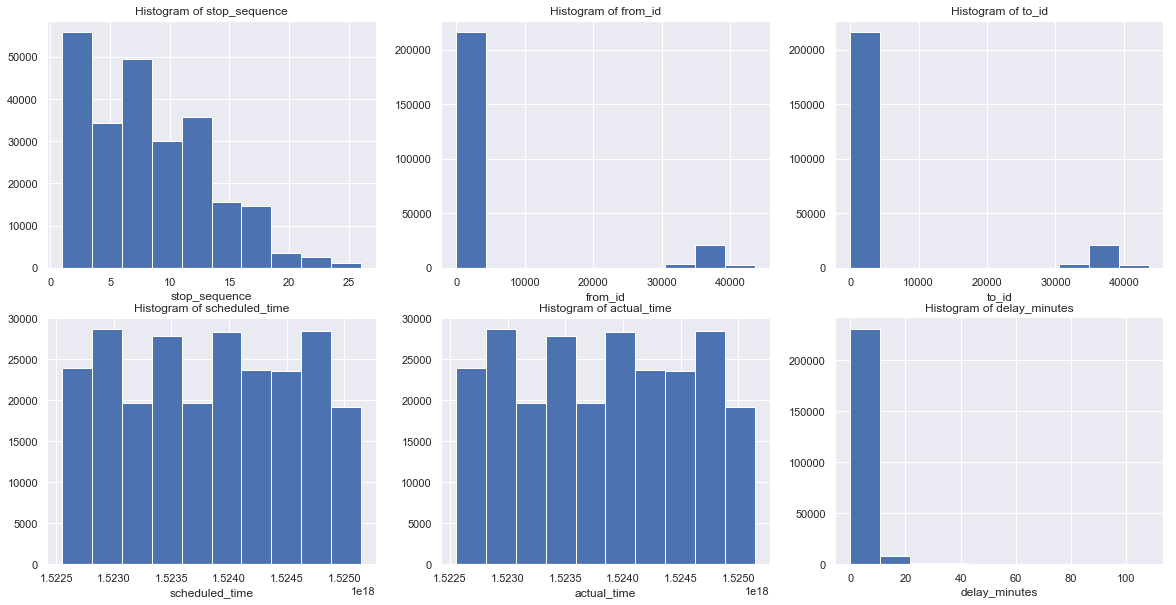

In [40]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.hist(df_trains.stop_sequence)
plt.title("Histogram of {}".format("stop_sequence"))
plt.xlabel('stop_sequence')

plt.subplot(2,3,2)
plt.hist(df_trains.from_id)
plt.title("Histogram of {}".format("from_id"))
plt.xlabel('from_id')

plt.subplot(2,3,3)
plt.hist(df_trains.to_id)
plt.title("Histogram of {}".format("to_id"))
plt.xlabel('to_id')

plt.subplot(2,3,4)
plt.hist(df_trains.scheduled_time)
plt.title("Histogram of {}".format("scheduled_time"))
plt.xlabel('scheduled_time')

plt.subplot(2,3,5)
plt.hist(df_trains.actual_time)
plt.title("Histogram of {}".format("actual_time"))
plt.xlabel('actual_time')

plt.subplot(2,3,6)
plt.hist(df_trains.delay_minutes)
plt.title("Histogram of {}".format("delay_minutes"))
plt.xlabel('delay_minutes')

plt.show()

In [41]:
df_trains.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242793 entries, 0 to 256261
Data columns (total 13 columns):
date              242793 non-null int64
train_id          242793 non-null object
stop_sequence     242793 non-null float64
from              242793 non-null object
from_id           242793 non-null int64
to                242793 non-null object
to_id             242793 non-null int64
scheduled_time    242793 non-null int64
actual_time       242793 non-null int64
delay_minutes     242793 non-null float64
status            242793 non-null object
line              242793 non-null object
type              242793 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 25.9+ MB


plan: use (date, stop_sequence, from_id, to_id, status) predict (delay_minutes > 2.15)


In [47]:
df_trains['status'].value_counts()

departed     219266
estimated     20803
cancelled      2724
Name: status, dtype: int64

In [49]:
status_cat = []

for idx, val in enumerate(df_trains['status']):
    if val == 'departed':
        status_cat.append(0)
    elif val == 'cancelled':
        status_cat.append(1)
    else:
        status_cat.append(2)
        
df_trains['status_cat'] = status_cat

In [50]:
df_trains['status_cat'].value_counts()

0    219266
2     20803
1      2724
Name: status_cat, dtype: int64

In [43]:
#Make a boolean version of the target for algorithmic friendliness
delay_minutes_bool = []

for idx, val in enumerate(df_trains['delay_minutes']):
    if val > 2.15:
        delay_minutes_bool.append(1)
    else:
        delay_minutes_bool.append(0)
        
df_trains['delay_minutes_bool'] = delay_minutes_bool

In [44]:
df_trains['delay_minutes_bool'].value_counts()

0    125184
1    117609
Name: delay_minutes_bool, dtype: int64

In [83]:
df_trains['status_cat'].value_counts()

0    219266
2     20803
1      2724
Name: status_cat, dtype: int64

In [76]:
X = df_trains[['date', 'stop_sequence', 'from_id', 'to_id', 'status_cat'
             ]]
y = df_trains['delay_minutes_bool']

In [77]:
X_norm = normalize(X)

In [78]:
n_comps = np.arange(0, 5)
param_grid_pca = [{'pca__n_components':n_comps}]
pipe_tree_pca = make_pipeline(PCA())

In [74]:
gs_pca = GridSearchCV(pipe_tree_pca, param_grid=param_grid_pca, cv=10)

In [90]:
gs_pca.fit(X_norm,y)
print(gs_pca.best_params_)

{'pca__n_components': 2}


In [91]:
#using the results of GridSearchCV to perform PCA

sklearn_pca = PCA(n_components=2)  
X_pca = sklearn_pca.fit_transform(X_norm)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA:\n',
    sklearn_pca.explained_variance_ratio_
)

#X_pca is now our PCA engineered feature set.

The percentage of total variance in the dataset explained by each component from Sklearn PCA:
 [0.54134796 0.45865195]


In [92]:
# Split the data into four equally-sized samples for analysis with silhouette. 
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca,
    y,
    test_size=0.1,
    random_state=42)

In [94]:
for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
    model = KMeans(n_clusters=2, random_state=42).fit(sample)
    labels_test = model.labels_
    print(metrics.silhouette_score(sample, labels_test, metric='euclidean'))

0.8267230240244137
0.82646792012113
0.8258613928384566
0.8247469440920112


In [86]:
for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
    model = KMeans(n_clusters=4, random_state=42).fit(sample)
    labels_test = model.labels_
    print(metrics.silhouette_score(sample, labels_test, metric='euclidean'))

0.9853018407487926
0.9855162652328855
0.9856614583791282
0.9857552491492663


In [87]:
for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
    model = KMeans(n_clusters=6, random_state=42).fit(sample)
    labels_test = model.labels_
    print(metrics.silhouette_score(sample, labels_test, metric='euclidean'))

0.9663477413649216
0.9683670932679037
0.9683236837394738
0.9693755182521809


In [88]:
y_pred = KMeans(n_clusters=2).fit(X_train)
labels = y_pred.labels_

In [89]:

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train, labels))

Comparing k-means clusters against the data:
col_0                    0      1
delay_minutes_bool               
0                   101165  11626
1                    92973  12749


## Model: Decision Tree

In [104]:
#setting up parameters for GridSearchCV(DecisionTreeClassifier())

depths = np.arange(1, 25)
num_features = [1, 2]

param_grid_dt_pca = [{'decisiontreeclassifier__max_depth':depths,
               'decisiontreeclassifier__max_features':num_features}]

pipe_tree_dt_pca = make_pipeline(tree.DecisionTreeClassifier(criterion='entropy'))

In [105]:
gs_dt_pca = GridSearchCV(pipe_tree_dt_pca, param_grid=param_grid_dt_pca, cv=10)

In [106]:
gs_dt_pca.fit(X_train,y_train)
print(gs_dt_pca.best_params_)

{'decisiontreeclassifier__max_depth': 1, 'decisiontreeclassifier__max_features': 1}


In [107]:
#initialize and train the decision tree model using GridSearchCV results
#    {'decisiontreeclassifier__max_depth': 20, 'decisiontreeclassifier__max_features': 7}

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=1
)

decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
                       max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [108]:
#making predictions for model evaluation
y_pred_dt = decision_tree.fit(X_train, y_train).predict(X_test)

In [109]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(decision_tree, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(decision_tree, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.51617627 0.51615413 0.51617775 0.51617775 0.51617775 0.51617775
 0.51617775 0.51617775 0.51617775 0.51617775]
The 10-fold cross validation average for the training set is  0.5161752390889882
--- 1.0046520233154297 seconds ---


In [110]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(decision_tree, X_test, y_test, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(decision_tree, X_test, y_test, cv=10).mean())

[0.51049815 0.51049815 0.51049815 0.51029654 0.51029654 0.51029654
 0.51029654 0.5105068  0.5105068  0.5105068 ]
The 10-fold cross validation average for the testing set  is  0.510420099915708


In [112]:
#classification report

print(classification_report(y_test, y_pred_dt, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68     12393
           1       0.00      0.00      0.00     11887

    accuracy                           0.51     24280
   macro avg       0.26      0.50      0.34     24280
weighted avg       0.26      0.51      0.34     24280



In [113]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_pred_dt, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[12393     0]
 [11887     0]]


## Model: Random Forest Classifier

In [114]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [115]:
#making predictions for model evaluation
y_preds_rfc=rfc.predict(X_test)

In [116]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(rfc, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(rfc, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.51617627 0.51615413 0.51617775 0.51617775 0.51617775 0.51617775
 0.51617775 0.51617775 0.51617775 0.51617775]
The 10-fold cross validation average for the training set is  0.5161752390889882
--- 7.489235162734985 seconds ---


In [117]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(rfc, X_test, y_test, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(rfc, X_test, y_test, cv=10).mean())

[0.51049815 0.51049815 0.51049815 0.51029654 0.51029654 0.51029654
 0.51029654 0.5105068  0.5105068  0.5105068 ]
The 10-fold cross validation average for the testing set  is  0.510420099915708


In [118]:
#classification report

print(classification_report(y_test, y_preds_rfc, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68     12393
           1       0.00      0.00      0.00     11887

    accuracy                           0.51     24280
   macro avg       0.26      0.50      0.34     24280
weighted avg       0.26      0.51      0.34     24280



In [119]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_preds_rfc, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[12393     0]
 [11887     0]]


## Model: SVM

In [120]:
#kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [1,2]
param_grid_svm = [{'svc__degree':degrees}]
pipe_tree_svm = make_pipeline(SVC(kernel = 'poly'))

In [121]:
gs_svm = GridSearchCV(pipe_tree_svm, param_grid=param_grid_svm, cv=10)

#gs_svm.get_params().keys()

In [139]:
gs_svm.fit(X_train,y_train)
print(gs_svm.best_params_)

{'svc__degree': 1}


In [141]:
svm = SVC(kernel='poly',degree=1)
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [142]:
#Setting the predictions for analysis
y_pred_svm = svm.fit(X_train, y_train).predict(X_test)

In [82]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(svm, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(svm, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.77239709 0.7566586  0.75728155 0.75485437 0.76334951 0.77063107
 0.78398058 0.76820388 0.77184466 0.78276699]
The 10-fold cross validation average for the training set is  0.7681968311431862
--- 25.259382963180542 seconds ---


In [83]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(svm, X_test, y_test, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(svm, X_test, y_test, cv=10).mean())

[0.79577465 0.72340426 0.80141844 0.80851064 0.79432624 0.77304965
 0.82857143 0.78571429 0.85       0.79285714]
The 10-fold cross validation average for the testing set  is  0.7953626724888336


In [84]:
#classification report

print(classification_report(y_test, y_pred_svm, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1041
           1       0.51      0.82      0.63       366

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.72      1407
weighted avg       0.82      0.75      0.77      1407



In [85]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_pred_svm, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[757 284]
 [ 65 301]]


## Model: Naive Bayes

In [124]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(X_train, y_train)

# Classify, storing the result in a new variable.
y_preds_nb = bnb.predict(X_test)

In [125]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(bnb, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(bnb, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.52354368 0.52773202 0.53297332 0.52491877 0.53137156 0.53063933
 0.52917487 0.52720699 0.53608531 0.53105121]
The 10-fold cross validation average for the training set is  0.5294697047303474
--- 0.9993929862976074 seconds ---


In [126]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(bnb, X_test, y_test, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(bnb, X_test, y_test, cv=10).mean())

[0.53149444 0.52573075 0.53766982 0.50411862 0.53995058 0.52594728
 0.53130148 0.51380305 0.5236918  0.5236918 ]
The 10-fold cross validation average for the testing set  is  0.5257399625877948


In [127]:
#classification report

print(classification_report(y_test, y_preds_nb, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.52      0.82      0.64     12393
           1       0.54      0.22      0.31     11887

    accuracy                           0.53     24280
   macro avg       0.53      0.52      0.47     24280
weighted avg       0.53      0.53      0.48     24280



In [128]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_preds_nb, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[10169  2224]
 [ 9291  2596]]


## Model: KNN

In [129]:
#kernels = ['linear', 'poly', 'rbf', 'sigmoid']
num_neighbors = np.arange(1, 25)
weights = ['distance','uniform']
leaf_sizes = np.arange(1, 40)

param_grid_knn = [{'kneighborsclassifier__n_neighbors':num_neighbors,
                      'kneighborsclassifier__weights':weights,
                      'kneighborsclassifier__leaf_size':leaf_sizes}
                     ]
pipe_tree_knn = make_pipeline(neighbors.KNeighborsClassifier())

In [130]:
gs_knn = GridSearchCV(pipe_tree_knn, param_grid=param_grid_knn, cv=10)

#gs_knn.get_params().keys()

In [140]:
gs_knn.fit(X_train,y_train)
print(gs_knn.best_params_)

{'kneighborsclassifier__leaf_size': 25, 'kneighborsclassifier__n_neighbors': 23, 'kneighborsclassifier__weights': 'uniform'}


In [143]:
#{'kneighborsclassifier__leaf_size': 29, 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'distance'}
knn = neighbors.KNeighborsClassifier(n_neighbors=23, weights='distance', leaf_size=25)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=25, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=23, p=2,
                     weights='distance')

In [144]:
# Classify, storing the result in a new variable.
y_preds_knn = knn.predict(X_test)

In [145]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(knn, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(knn, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.63510731 0.63239063 0.63809437 0.6353485  0.64120635 0.63855201
 0.63891813 0.63791131 0.64074871 0.63800284]
The 10-fold cross validation average for the training set is  0.6376280142545252
--- 6.249262094497681 seconds ---


In [146]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(knn, X_test, y_test, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(knn, X_test, y_test, cv=10).mean())

[0.61506793 0.61300947 0.62453685 0.60172982 0.61655684 0.60131796
 0.5976112  0.61351463 0.62175525 0.61557478]
The 10-fold cross validation average for the testing set  is  0.6120674724225557


In [147]:
#classification report

print(classification_report(y_test, y_preds_knn, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.64      0.67      0.66     12393
           1       0.64      0.61      0.62     11887

    accuracy                           0.64     24280
   macro avg       0.64      0.64      0.64     24280
weighted avg       0.64      0.64      0.64     24280



In [148]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_preds_knn, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[8302 4091]
 [4647 7240]]
